In [2]:
import MDAnalysis as mda
from MDAnalysis.analysis import rms
from MDAnalysis.analysis import align
from MDAnalysis.analysis.align import AlignTraj
from MDAnalysis.analysis.rms import RMSD
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from matplotlib import cm

/home/dcooper/anaconda3/envs/mda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Caculate RMSDs for all drugs 
rmsd_dict = {}
mother_dir = '../../drugs'
for analogue in os.listdir(mother_dir): 
    working_dir = f'{mother_dir}/{analogue}'
    pdb_fn = f'{working_dir}/system_{analogue}_crys.pdb'
    poses = f'{working_dir}/analysis/poses.dcd'

    crys = mda.Universe(pdb_fn) 
    no_hoh = crys.select_atoms('not resname HOH')
    no_hoh_fn = f'{working_dir}/complex_no_waters.pdb'
    no_hoh.write(no_hoh_fn)
    u = mda.Universe(no_hoh_fn, poses)

    def calc_RMSD(mobile, ref):
        R = RMSD(mobile, ref, select='backbone', groupselections=['resname UNL'])
        R.run()
        rmsd = R.rmsd.T
        rmsd = np.array(rmsd)
        return rmsd

    rmsd = calc_RMSD(u, crys)
    rmsd = rmsd [3]

    rmsd_dict[analogue] = rmsd

rmsd_dict

/home/dcooper/anaconda3/envs/mda/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/home/dcooper/anaconda3/envs/mda/lib/python3.10/site-packages/MDAnalysis/analysis/rms.py:718: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


{'FH210': array([9.86263554, 8.31885186, 5.50943804]),
 'mp': array([3.95214098, 4.06805806, 3.9701969 , 3.84436425, 4.18108506,
        4.13692047, 8.88766586]),
 'DAMGO': array([4.05041351, 5.87900304, 4.77615448, 5.25258738, 5.4294673 ,
        4.25570848]),
 'SR17018': array([2.86712391, 2.04593809, 2.62844236, 3.20970264, 2.89334894]),
 'fentanyl': array([7.88474063, 8.75631857, 3.84978053, 7.81689401, 9.11299768,
        2.90643773, 2.87882005]),
 'c5guano': array([11.44666256, 10.95585598, 11.42252129, 10.91550814,  9.05535264,
        11.4195035 ,  8.90465091]),
 'morphine': array([6.09588468, 6.55109805, 5.80186344, 6.02746309, 5.69122472,
        3.68924946, 7.01357444]),
 'c6guano': array([9.73997745, 9.22023018, 9.31683917, 9.55565635, 7.45393778,
        3.70198309, 2.364249  , 7.4558575 , 9.3789437 , 2.44856963]),
 'TRV130': array([ 3.63202497,  3.65802404,  3.08805315,  8.72485184,  3.87877707,
         8.77740692, 10.17490225]),
 'PZM21': array([6.5489375 , 3.25729812, 

In [4]:
# Load Other Information
df = pd.read_excel('Cluster_Info.xlsx', header=None, index_col=0, sheet_name='Sheet1')

ie_dict = {}
cluster_sizes_dict = {}
docking_score_dict ={}

for analogue in os.listdir(mother_dir):
    cluster_sizes_dict[analogue] = df.loc[analogue].iloc[0]
    ie_dict[analogue] = df.loc[analogue].iloc[1]


df2 = pd.read_excel('Cluster_Info.xlsx', header=0, index_col=0, sheet_name='Sheet2')
for analogue in os.listdir(mother_dir):
    docking_score_dict[analogue] = df2.loc[analogue]


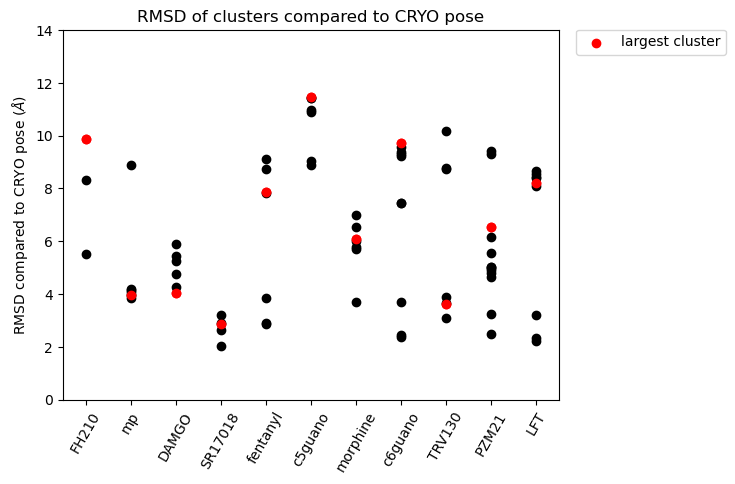

In [5]:
# Plot RMSDs with largest cluster
analogues = []
for analogue, rmsds in rmsd_dict.items():
    analogues.append(analogue)

fig, ax = plt.subplots()

spacer = 0
for analogue, rmsd in rmsd_dict.items():
    cluster_sizes_arr = []
    for size in cluster_sizes_dict[analogue]:
        if size/1 == size:
            cluster_sizes_arr.append(size)
    cluster_sizes_norm = np.array(100*((cluster_sizes_arr)/np.sum(cluster_sizes_arr)))
    
    plt.scatter(x=spacer, y=rmsd[0], c='red')
    plt.scatter(x=[spacer for i in range(len(rmsd)-1)], y=rmsd[1::], c='black')
    plt.scatter(x=spacer, y=rmsd[0], c='red')

    spacer += 1

ax.set_ylabel('RMSD compared to CRYO pose ($\AA$)')
ax.legend(['largest cluster'], bbox_to_anchor=[1.35, 1.02])
ax.set_ylim(0, 14)
ax.set_title('RMSD of clusters compared to CRYO pose')
ax.set_xticks(ticks=[i for i in range(len(analogues))], rotation=60, labels  = analogues)
plt.show()


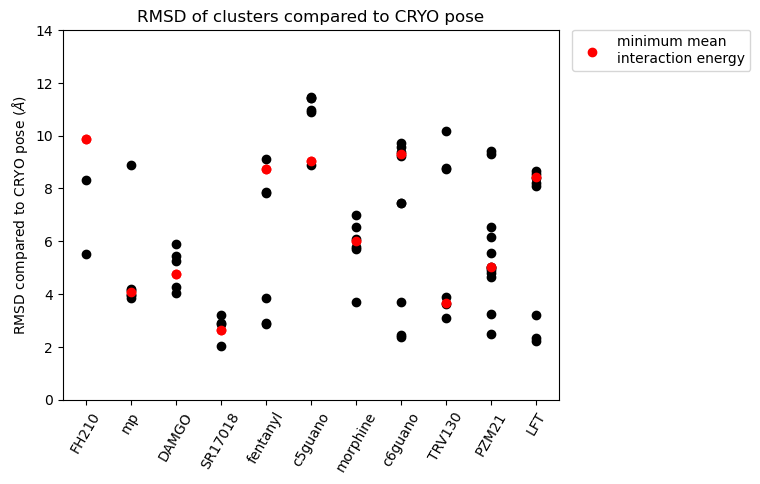

In [6]:
# Plot RMSDs with min mean interaction energy
analogues = []
for analogue, rmsds in rmsd_dict.items():
    analogues.append(analogue)

fig, ax = plt.subplots()

spacer = 0
for analogue, rmsd in rmsd_dict.items():
    ie_min = 0
    ie_min_ind = 0
    counter = 0
    for energy in ie_dict[analogue]:
        if energy/1 == energy:
            if energy < ie_min:
                ie_min = energy
                ie_min_ind = counter
        counter += 1
    arr_before = rmsd[:ie_min_ind]
    spacer_before = [spacer for i in range(ie_min_ind)]
    arr_after = rmsd[ie_min_ind+1:]
    spacer_after = [spacer for i in range(ie_min_ind+1, len(rmsd))]


    ax.scatter(x=spacer, y=rmsd[ie_min_ind], c='red')
    ax.scatter(x=spacer_before, y=arr_before, c='black')
    ax.scatter(x=spacer_after, y=arr_after, c='black')
    ax.scatter(x=spacer, y=rmsd[ie_min_ind], c='red')


    spacer += 1

import matplotlib.lines as mlines
ax.set_ylabel('RMSD compared to CRYO pose ($\AA$)')
ax.set_ylim(0, 14)

ax.set_title('RMSD of clusters compared to CRYO pose')
ax.legend(['minimum mean\ninteraction energy'], bbox_to_anchor=[1.4, 1.02])
ax.set_xticks(ticks=[i for i in range(len(analogues))], rotation=60, labels  = analogues)
plt.show()


In [7]:
# Docking scores rmsd_dict 

docking_rmsd_dict = {'FH210': [10.100211113511005,
  4.63190623444457,
  6.036212384599877,
  4.462894504889307,
  4.891861623445243,
  9.618673653676733,
  9.326644925097549,
  10.028370900291062,
  6.619343357259671,
  9.059707736438604,
  5.7860915760936935,
  4.946459553250842,
  8.694830518870782,
  8.6603686119577,
  9.403849717523016,
  5.2052915665894774,
  4.840315186270741,
  8.472184384146624,
  9.653057401859959,
  5.108492099241878],
 'mp': [4.716228515265314,
  8.831738923711724,
  4.267003476806781,
  7.854038889970928,
  4.310366804406693,
  8.858983090101544,
  4.229084013655397,
  3.995967077053752,
  7.558320879601537,
  4.6808118496160835,
  4.266247379225381,
  9.185983161746757,
  8.28101762372586,
  7.442703582947492,
  9.085365989924242,
  4.803173461076272,
  8.936472504924668,
  5.843885631461242,
  3.666177225116425,
  8.891767872795869],
 'DAMGO': [4.705270634685123,
  5.644186929960009,
  4.955730256376276,
  4.831172126924881,
  8.43437201085551,
  8.401744644168824,
  4.201384423880638,
  8.351084907546126,
  4.187828981881338,
  4.327234601069698,
  9.353995683283046,
  5.257406164667649,
  4.852499058918206,
  8.295464346895784,
  9.08499298980161,
  8.892230982667462,
  5.791113148770978,
  4.438705043036408,
  4.134531734039914,
  6.033180497977246],
 'SR17018': [6.1672857020113465,
  3.0334291267689477,
  6.615184087081699,
  7.546917197291138,
  8.440677760277348,
  5.504759501476326,
  6.0991314062906765,
  3.8693743381163634,
  6.938801493773814,
  6.538361835735787,
  3.76456621957261,
  6.655613825987795,
  6.263204324599506,
  2.1938092368971347,
  2.66121654071777,
  2.521027983845686,
  8.374691667151785,
  5.71996576352638,
  4.09694469986974,
  4.197882554131404],
 'fentanyl': [7.691954742338261,
  9.264734385719736,
  7.988864984034819,
  7.913197976189409,
  7.646569432302988,
  7.7757928113934645,
  4.93905237735471,
  7.635467782712816,
  7.162096543571276,
  7.976410453410577,
  7.55706423199908,
  7.2221857353037935,
  6.990269220295369,
  8.000533142290303,
  2.842629765886927,
  7.57229602949612,
  6.447173641197666,
  9.218643643247303,
  4.014426026475132,
  7.850738511173687],
 'c5guano': [4.0780197075573135,
  2.9918863606202315,
  8.269224958884346,
  7.108612706431744,
  9.138570533219832,
  8.802544741821723,
  3.470375481724272,
  8.412770846783408,
  3.331364287000235,
  10.15480515099878,
  8.378580030630046,
  10.329186178041907,
  9.872137544141241,
  8.649291916425321,
  10.651199265278471,
  12.606297167952894,
  11.15745234863979,
  6.428977752369735,
  11.459546672166365,
  10.75172966064344],
 'morphine': [5.430225848857951,
  4.448183383672294,
  9.263624685335957,
  7.908066949546073,
  5.5569038232726875,
  5.4979379917739015,
  5.186598227232806,
  10.300530497326687,
  5.8403294700052495,
  7.9243046056821065,
  4.996564510126839,
  9.262999424802718,
  8.2531448372273,
  5.890691143785642,
  9.236893905015926,
  6.2967712533597515,
  4.306777455209544,
  4.17716534618371,
  1.87345124487735,
  5.022707197579007],
 'c6guano': [3.635579652488836,
  8.89664558255493,
  8.77028412365119,
  9.596308593445926,
  3.9546942939938154,
  9.87308555007188,
  7.897767810232295,
  8.227167231697004,
  8.973270872516018,
  10.835491997802052,
  3.2268710303827683,
  9.529353963852508,
  8.945995729747958,
  9.859012816776778,
  9.547262647908768,
  9.372457140298996,
  2.3484867721081146,
  2.7907326020607575,
  8.919693361982908,
  8.020574871641985],
 'TRV130': [6.918094915126532,
  6.509990260677127,
  6.344563990821199,
  3.5652971414849124,
  2.7938656562116573,
  3.478305992930804,
  4.825683146382035,
  6.511182516809147,
  7.303705458833398,
  7.15341616006603,
  9.810930220540406,
  6.541038875326773,
  6.723222689202039,
  6.577582860363986,
  6.438941522203612,
  6.986895889734352,
  9.990201068228354,
  5.111221504772087,
  6.331275213249241,
  3.5428201685690683],
 'PZM21': [4.257168452779247,
  6.101887276301301,
  5.016004743552738,
  4.999283545290324,
  4.960862157343427,
  9.485713915127645,
  4.628734302077918,
  7.909596589465571,
  6.8285706150322465,
  8.844248770827555,
  6.952154218017334,
  4.599866042113482,
  5.4237805776805486,
  4.144372451856519,
  5.0274556787247855,
  4.859193282355828,
  5.825826348130198,
  8.99450677739724,
  4.924436280143755,
  3.265694632516102],
 'LFT': [7.851075602478264,
  2.044441397371634,
  7.493754723786825,
  2.3984573514388527,
  3.712567619349498,
  5.093416430348543,
  7.365799574438926,
  7.4644345811248645,
  8.20885464535705,
  7.844175481370441,
  7.948686555676865,
  8.024917149684164,
  5.3535556830321385,
  5.122529838408217,
  9.064042409874846,
  7.9869261354161125,
  8.553287239057926,
  8.604183607912411,
  5.451069174354613,
  8.046512659830578]}

4


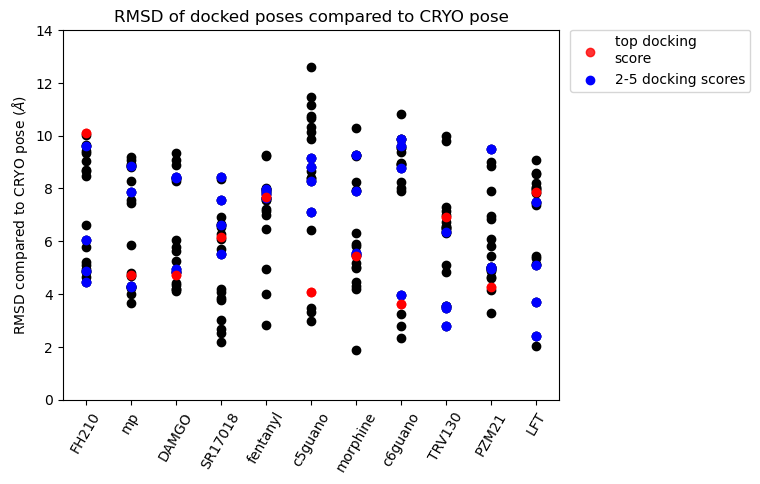

In [8]:
# Plot RMSDs of docking
analogues = []
for analogue, rmsds in docking_rmsd_dict.items():
    analogues.append(analogue)

fig, ax = plt.subplots()
print(len(rmsd[2:6]))
spacer = 0
for analogue, rmsd in docking_rmsd_dict.items():

    ax.scatter(x=spacer, y=rmsd[0], c='red', label = 'top docking score', alpha = 0.8)
    ax.scatter(x=[spacer for i in range(4)], y=rmsd[2:6], c='blue', label = '2-5 docking scores', alpha=1.0)
    ax.scatter(x=[spacer for i in range(len(rmsd)-1)], y=rmsd[1:], c='black', alpha = 1.0)
    ax.scatter(x=[spacer for i in range(4)], y=rmsd[2:6], c='blue', label = '2-5 docking scores', alpha=1.0)
    ax.scatter(x=spacer, y=rmsd[0], c='red', label = 'top docking score', alpha = 1.0)



    spacer += 1

import matplotlib.lines as mlines
ax.set_ylabel('RMSD compared to CRYO pose ($\AA$)')
ax.set_title('RMSD of docked poses compared to CRYO pose')
ax.set_ylim(0,14)
ax.legend(['top docking\nscore', '2-5 docking scores'], bbox_to_anchor=[1.4, 1.02])
ax.set_xticks(ticks=[i for i in range(len(analogues))], rotation=60, labels = analogues)
plt.show()


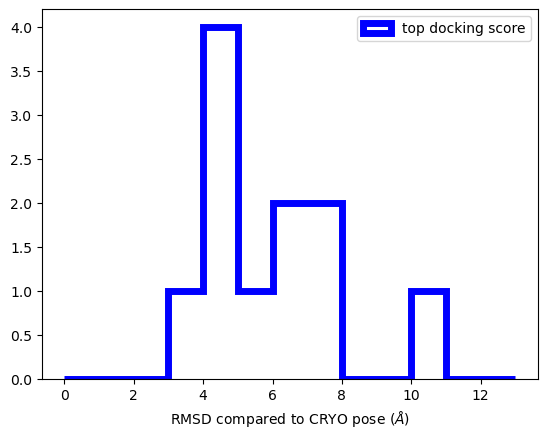

In [8]:
# Comparison plot 

# Get RMSD of top docking score
top_docking_score_rmsd = []
for analogue, rmsd in docking_rmsd_dict.items():
    top_docking_score_rmsd.append(rmsd[0])

# Get RMSD of larges cluster 
first_cluster_rmsd = []
for analogue, rmsd in rmsd_dict.items():
    first_cluster_rmsd.append(rmsd[0])

# Get RMSD of min mean interaction energy 
min_mean_interaction_energy_rmsd = []
for analogue, rmsd in rmsd_dict.items():
    ie_min = 0
    ie_min_ind = 0
    counter = 0
    for energy in ie_dict[analogue]:
        if energy/1 == energy:
            if energy < ie_min:
                ie_min = energy
                ie_min_ind = counter
        counter += 1

    min_mean_interaction_energy_rmsd.append(rmsd[ie_min_ind])

docking_n, docking_bins, patches = plt.hist(top_docking_score_rmsd, range=[0,15], bins=[i for i in range(14)], histtype='step', color='blue', linewidth = 5, label = 'top docking score')
plt.xlabel('RMSD compared to CRYO pose ($\AA$)')

plt.legend()
plt.show()

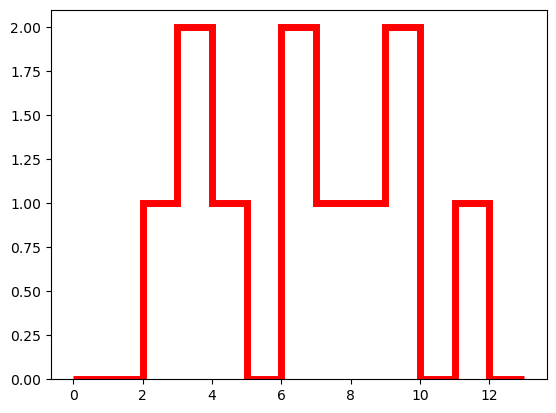

In [9]:
# Histogram of first cluster rmsd
cluster_n, cluster_bins, dummy = plt.hist(first_cluster_rmsd, range=[0,15], bins = [i for i in range(14)], histtype='step', color='red', linewidth = 5, label='first cluster')


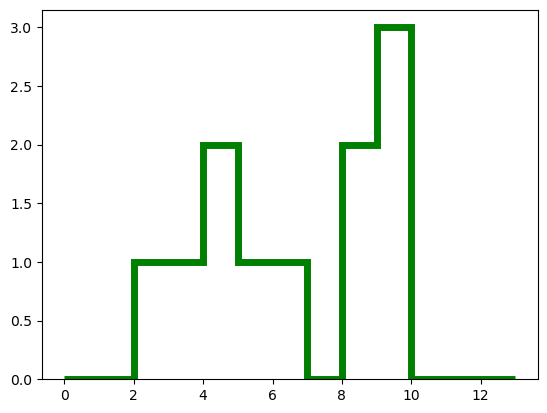

In [10]:
# Histogram for min mean interaction energy_rmsd
ie_n, ie_bins, dummy = plt.hist(min_mean_interaction_energy_rmsd, range=[0,15], bins = [i for i in range(14)], histtype='step', color='green', linewidth = 5, label='first cluster')

Text(0, 0.5, 'Count')

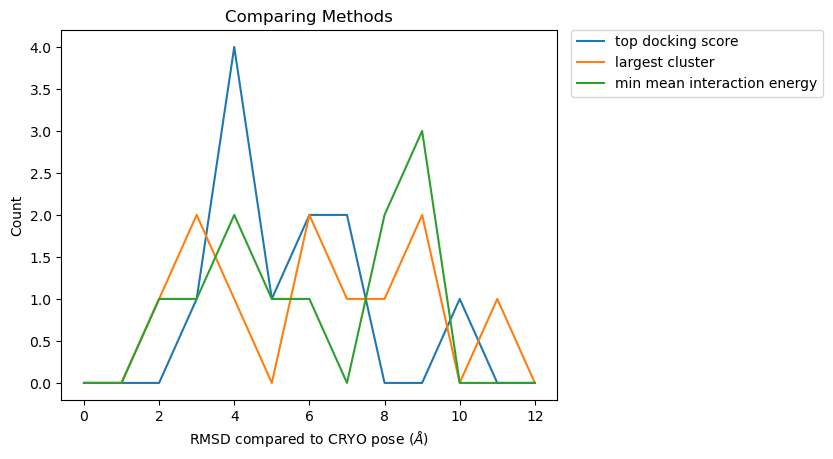

In [11]:
plt.plot([docking_bins[i] for i in range(len(docking_n))], docking_n, label = 'top docking score')
plt.plot([cluster_bins[i] for i in range(len(cluster_n))], cluster_n, label = 'largest cluster')
plt.plot([ie_bins[i] for i in range(len(ie_n))], ie_n, label = 'min mean interaction energy')
plt.title('Comparing Methods')
plt.legend( bbox_to_anchor=[1.55, 1.02])
plt.xlabel('RMSD compared to CRYO pose ($\AA$)')
plt.ylabel('Count')

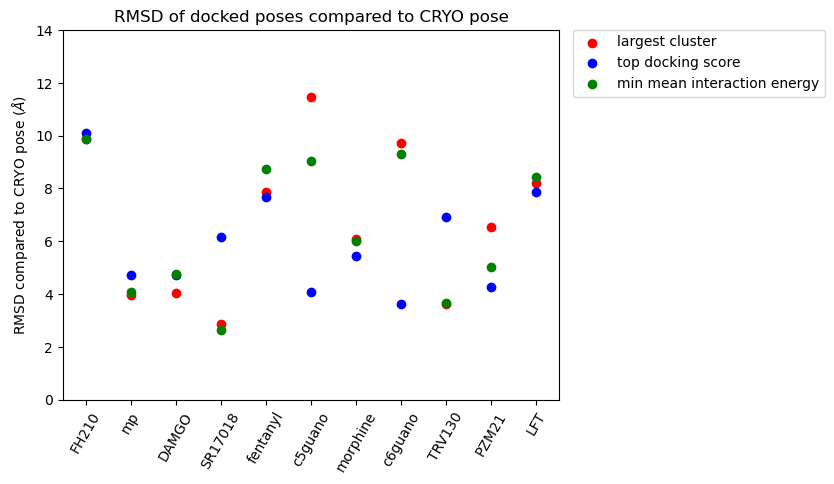

In [12]:
# Different Comparative Plot
spacer = 0 
fig, ax = plt.subplots()
for analogue, rmsd in rmsd_dict.items():
    ax.scatter(spacer, rmsd[0], color = 'red')
    ax.scatter(spacer, top_docking_score_rmsd[spacer], color='blue')
    ax.scatter(spacer, min_mean_interaction_energy_rmsd[spacer], color='green')
    spacer += 1

plt.legend(['largest cluster', 'top docking score', 'min mean interaction energy'], bbox_to_anchor=[1.55, 1.02] )
ax.set_ylabel('RMSD compared to CRYO pose ($\AA$)')
ax.set_title('RMSD of docked poses compared to CRYO pose')
ax.set_ylim(0,14)
ax.set_xticks(ticks=[i for i in range(len(analogues))], rotation=60, labels = analogues)
plt.show()

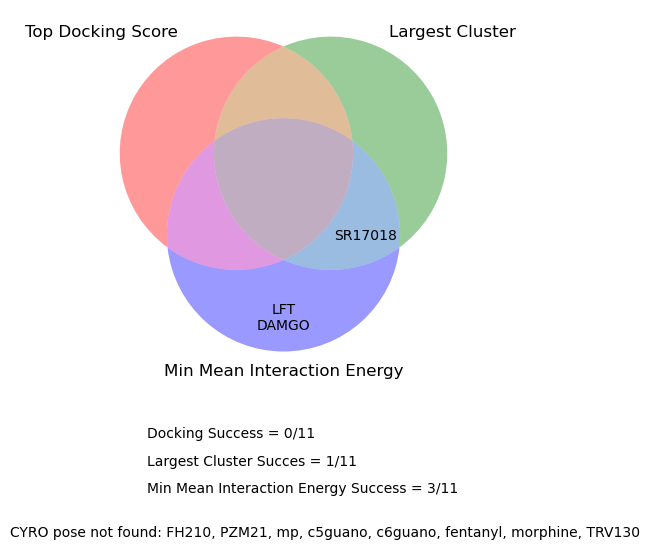

In [13]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3_unweighted

set1 = set([]) #docking
set2 = set(['SR17018']) #clusters
set3 = set(['SR17018', 'LFT', 'DAMGO']) #ie
venn = venn3_unweighted([set1, set2, set3], ('Top Docking Score', 'Largest Cluster', 'Min Mean Interaction Energy'))
venn.get_label_by_id('100').set_text('\n'.join(set1-set2-set3))
venn.get_label_by_id('110').set_text('\n'.join(set1&set2-set3))
venn.get_label_by_id('010').set_text('\n'.join(set2-set3-set1))
venn.get_label_by_id('101').set_text('\n'.join(set1&set3-set2))
venn.get_label_by_id('111').set_text('\n'.join(set1&set2&set3))
venn.get_label_by_id('011').set_text('\n'.join(set2&set3-set1))
venn.get_label_by_id('011').set_size(10)
venn.get_label_by_id('011').set_position([.3,-.2])
venn.get_label_by_id('001').set_text('\n'.join(set3-set2-set1))

plt.text(x=-0.5, y=-1, s='Docking Success = 0/11\n')
plt.text(x=-0.5, y=-1.1, s='Largest Cluster Succes = 1/11\n')
plt.text(x=-0.5, y=-1.2, s='Min Mean Interaction Energy Success = 3/11\n')
plt.text(x=-1, y=-1.3, s='CYRO pose not found: FH210, PZM21, mp, c5guano, c6guano, fentanyl, morphine, TRV130')

plt.show()

In [14]:
docking_score_dict['fentanyl']

1    -8.597
2    -8.552
3    -8.381
4    -8.336
5    -8.262
6    -8.254
7    -8.240
8    -8.093
9    -8.007
10   -8.000
11   -7.894
12   -7.803
13   -7.716
14   -7.696
15   -7.605
16   -7.564
17   -7.523
18   -7.482
19   -7.441
20   -7.400
Name: fentanyl, dtype: float64

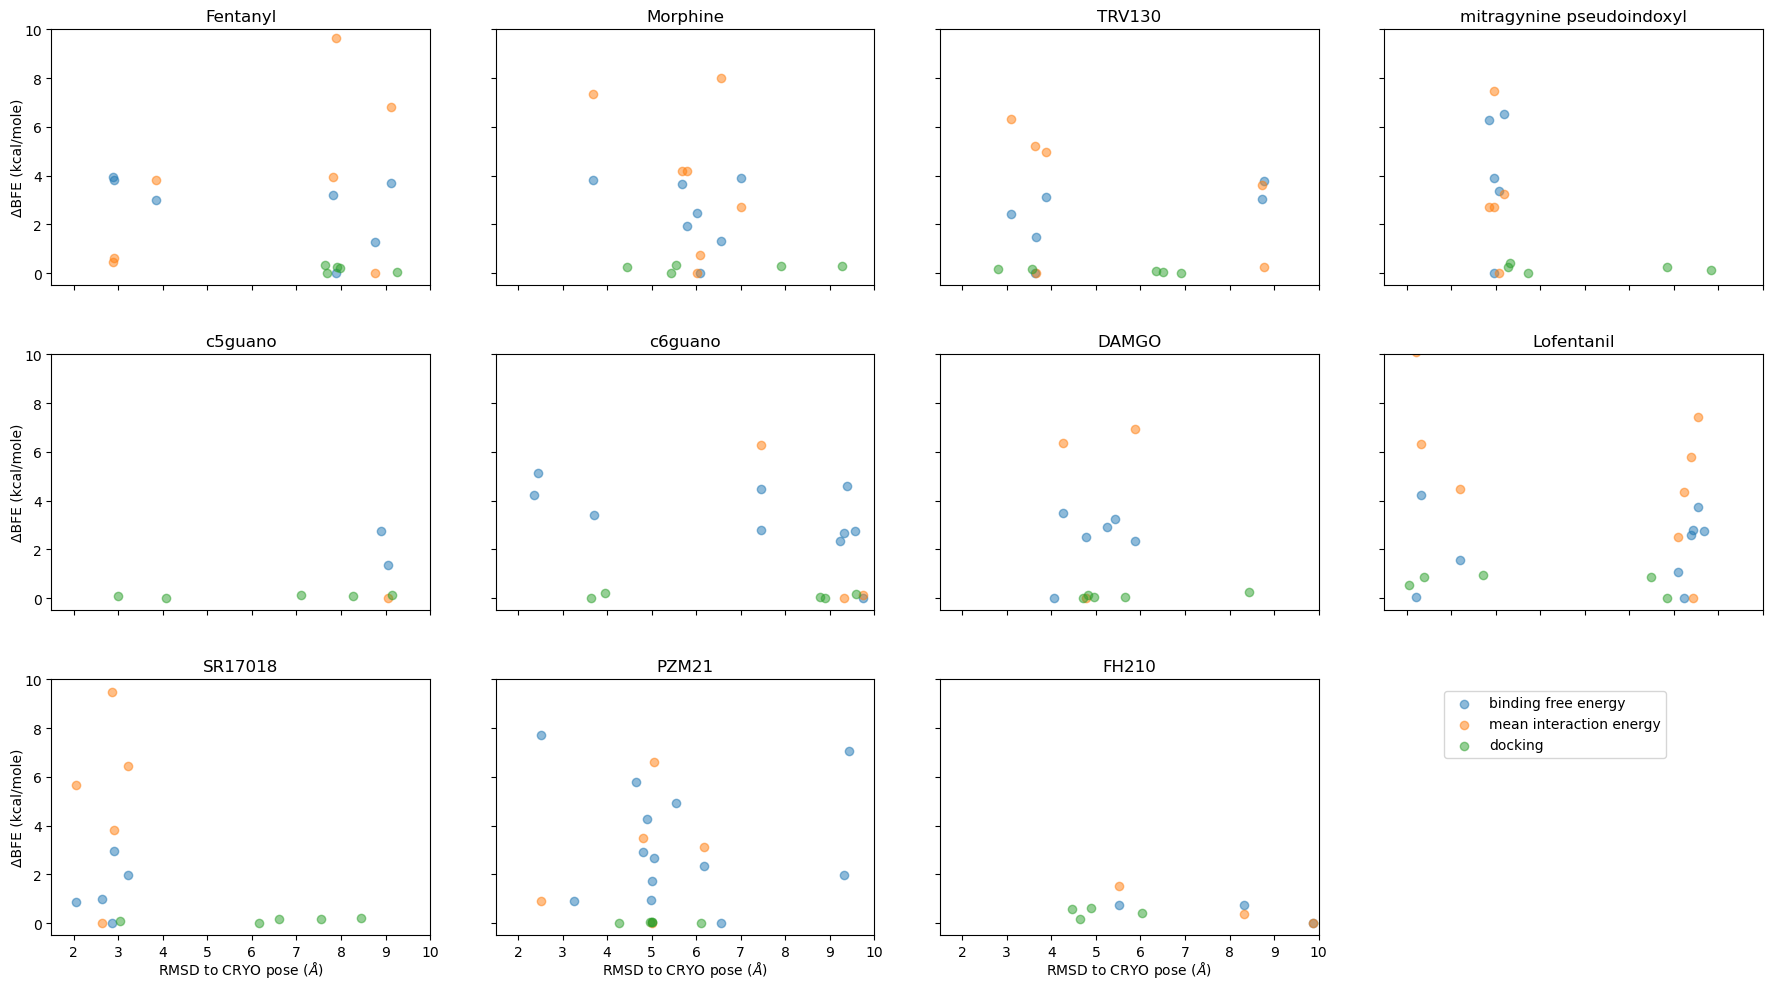

In [15]:
# Let's restart here and try again ok, you can do this lol

def delta_G_clusters(cluster_size_arr, rmsd_dict):
    no_clusters = rmsd_dict.size
    delta_G_arr = np.zeros(no_clusters)
    for i in range(no_clusters):
        delta_G_arr[i] = -8.3145*300*np.log((cluster_size_arr.iloc[i])/(cluster_size_arr.iloc[0]))
    return delta_G_arr/1000

def delta_G_ie(ie_arr, rmsd_dict):
    no_clusters = rmsd_dict.size
    delta_G_arr = np.zeros(no_clusters)

    min_ie = 0
    for energy in ie_arr:
        if energy<min_ie:
            min_ie = energy

    for i in range(no_clusters):
        delta_G_arr[i] = ie_arr.iloc[i] - min_ie

    return delta_G_arr

def delta_G_docking(docking_scores_arr):
    return np.array([docking_scores_arr.iloc[i]-docking_scores_arr.iloc[0] for i in range(5)])




fig, ax = plt.subplots(3,4, figsize=(18,10))

#fentanyl 
fentanyl_rel_BFEs = delta_G_clusters(cluster_sizes_dict['fentanyl'], rmsd_dict['fentanyl'])
fentanyl_ies = delta_G_ie(ie_dict['fentanyl'], rmsd_dict['fentanyl'])
fentanyl_docking_scores = delta_G_docking(docking_score_dict['fentanyl'])
ax[0,0].scatter(rmsd_dict['fentanyl'], fentanyl_rel_BFEs, label = 'binding free energy', alpha=0.5)
ax[0,0].scatter(rmsd_dict['fentanyl'], fentanyl_ies, label = 'mean interaction energy', alpha=0.5)
ax[0,0].scatter(docking_rmsd_dict['fentanyl'][:5], fentanyl_docking_scores, label = 'docking', alpha=0.5)
ax[0,0].set_title('Fentanyl')

#morphine 
morphine_rel_BFEs = delta_G_clusters(cluster_sizes_dict['morphine'], rmsd_dict['morphine'])
morphine_ies = delta_G_ie(ie_dict['morphine'], rmsd_dict['morphine'])
morphine_docking_scores = delta_G_docking(docking_score_dict['morphine'])
ax[0,1].scatter(rmsd_dict['morphine'], morphine_rel_BFEs, label = 'binding free energy', alpha=0.5)
ax[0,1].scatter(rmsd_dict['morphine'], morphine_ies, label = 'mean interaction energy', alpha=0.5)
ax[0,1].scatter(docking_rmsd_dict['morphine'][:5], morphine_docking_scores, label = 'docking', alpha=0.5)
ax[0,1].set_title('Morphine')

#TRV130
TRV130_rel_BFEs = delta_G_clusters(cluster_sizes_dict['TRV130'], rmsd_dict['TRV130'])
TRV130_ies = delta_G_ie(ie_dict['TRV130'], rmsd_dict['TRV130'])
TRV130_docking_scores = delta_G_docking(docking_score_dict['TRV130'])
ax[0,2].scatter(rmsd_dict['TRV130'], TRV130_rel_BFEs, label = 'binding free energy', alpha=0.5)
ax[0,2].scatter(rmsd_dict['TRV130'], TRV130_ies, label = 'mean interaction energy', alpha=0.5)
ax[0,2].scatter(docking_rmsd_dict['TRV130'][:5], TRV130_docking_scores, label = 'docking', alpha=0.5)
ax[0,2].set_title('TRV130')

#mitragynine pseudoindoxyl
mp_rel_BFEs = delta_G_clusters(cluster_sizes_dict['mp'], rmsd_dict['mp'])
mp_ies = delta_G_ie(ie_dict['mp'], rmsd_dict['mp'])
mp_docking_scores = delta_G_docking(docking_score_dict['mp'])
ax[0,3].scatter(rmsd_dict['mp'], mp_rel_BFEs, label = 'binding free energy', alpha=0.5)
ax[0,3].scatter(rmsd_dict['mp'], mp_ies, label = 'mean interaction energy', alpha=0.5)
ax[0,3].scatter(docking_rmsd_dict['mp'][:5], mp_docking_scores, label = 'docking', alpha=0.5)
ax[0,3].set_title('mitragynine pseudoindoxyl')

#c5guano
c5guano_rel_BFEs = delta_G_clusters(cluster_sizes_dict['c5guano'], rmsd_dict['c5guano'])
c5guano_ies = delta_G_ie(ie_dict['c5guano'], rmsd_dict['c5guano'])
c5guano_docking_scores = delta_G_docking(docking_score_dict['c5guano'])
ax[1,0].scatter(rmsd_dict['c5guano'], c5guano_rel_BFEs, label = 'binding free energy', alpha=0.5)
ax[1,0].scatter(rmsd_dict['c5guano'], c5guano_ies, label = 'mean interaction energy', alpha=0.5)
ax[1,0].scatter(docking_rmsd_dict['c5guano'][:5], c5guano_docking_scores, label = 'docking', alpha=0.5)
ax[1,0].set_title('c5guano')

#c6guano
c6guano_rel_BFEs = delta_G_clusters(cluster_sizes_dict['c6guano'], rmsd_dict['c6guano'])
c6guano_ies = delta_G_ie(ie_dict['c6guano'], rmsd_dict['c6guano'])
c6guano_docking_scores = delta_G_docking(docking_score_dict['c6guano'])
ax[1,1].scatter(rmsd_dict['c6guano'], c6guano_rel_BFEs, label = 'binding free energy', alpha=0.5)
ax[1,1].scatter(rmsd_dict['c6guano'], c6guano_ies, label = 'mean interaction energy', alpha=0.5)
ax[1,1].scatter(docking_rmsd_dict['c6guano'][:5], c6guano_docking_scores, label = 'docking', alpha=0.5)
ax[1,1].set_title('c6guano')

#DAMGO
DAMGO_rel_BFEs = delta_G_clusters(cluster_sizes_dict['DAMGO'], rmsd_dict['DAMGO'])
DAMGO_ies = delta_G_ie(ie_dict['DAMGO'], rmsd_dict['DAMGO'])
DAMGO_docking_scores = delta_G_docking(docking_score_dict['DAMGO'])
ax[1,2].scatter(rmsd_dict['DAMGO'], DAMGO_rel_BFEs, label = 'binding free energy', alpha=0.5)
ax[1,2].scatter(rmsd_dict['DAMGO'], DAMGO_ies, label = 'mean interaction energy', alpha=0.5)
ax[1,2].scatter(docking_rmsd_dict['DAMGO'][:5], DAMGO_docking_scores, label = 'docking', alpha=0.5)
ax[1,2].set_title('DAMGO')

#Lofentanil
LFT_rel_BFEs = delta_G_clusters(cluster_sizes_dict['LFT'], rmsd_dict['LFT'])
LFT_ies = delta_G_ie(ie_dict['LFT'], rmsd_dict['LFT'])
LFT_docking_scores = delta_G_docking(docking_score_dict['LFT'])
ax[1,3].scatter(rmsd_dict['LFT'], LFT_rel_BFEs, label = 'binding free energy', alpha=0.5)
ax[1,3].scatter(rmsd_dict['LFT'], LFT_ies, label = 'mean interaction energy', alpha=0.5)
ax[1,3].scatter(docking_rmsd_dict['LFT'][:5], LFT_docking_scores, label = 'docking', alpha=0.5)
ax[1,3].set_title('Lofentanil')

#SR17018
SR17018_rel_BFEs = delta_G_clusters(cluster_sizes_dict['SR17018'], rmsd_dict['SR17018'])
SR17018_ies = delta_G_ie(ie_dict['SR17018'], rmsd_dict['SR17018'])
SR17018_docking_scores = delta_G_docking(docking_score_dict['SR17018'])
ax[2,0].scatter(rmsd_dict['SR17018'], SR17018_rel_BFEs, label = 'binding free energy', alpha=0.5)
ax[2,0].scatter(rmsd_dict['SR17018'], SR17018_ies, label = 'mean interaction energy', alpha=0.5)
ax[2,0].scatter(docking_rmsd_dict['SR17018'][:5], SR17018_docking_scores, label = 'docking', alpha=0.5)
ax[2,0].set_title('SR17018')

#PZM21
PZM21_rel_BFEs = delta_G_clusters(cluster_sizes_dict['PZM21'], rmsd_dict['PZM21'])
PZM21_ies = delta_G_ie(ie_dict['PZM21'], rmsd_dict['PZM21'])
PZM21_docking_scores = delta_G_docking(docking_score_dict['PZM21'])
ax[2,1].scatter(rmsd_dict['PZM21'], PZM21_rel_BFEs, label = 'binding free energy', alpha=0.5)
ax[2,1].scatter(rmsd_dict['PZM21'], PZM21_ies, label = 'mean interaction energy', alpha=0.5)
ax[2,1].scatter(docking_rmsd_dict['PZM21'][:5], PZM21_docking_scores, label = 'docking', alpha=0.5)
ax[2,1].set_title('PZM21')

#FH210
FH210_rel_BFEs = delta_G_clusters(cluster_sizes_dict['FH210'], rmsd_dict['FH210'])
FH210_ies = delta_G_ie(ie_dict['FH210'], rmsd_dict['FH210'])
FH210_docking_scores = delta_G_docking(docking_score_dict['FH210'])
ax[2,2].scatter(rmsd_dict['FH210'], FH210_rel_BFEs, label = 'binding free energy', alpha=0.5)
ax[2,2].scatter(rmsd_dict['FH210'], FH210_ies, label = 'mean interaction energy', alpha=0.5)
ax[2,2].scatter(docking_rmsd_dict['FH210'][:5], FH210_docking_scores, label = 'docking', alpha=0.5)
ax[2,2].set_title('FH210')

fig.tight_layout(pad=1.8)
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(.93,0.3))

ax[2,3].set_axis_off()


for ax in ax.flat:
    ax.set_ylabel('\u0394BFE (kcal/mole)',labelpad=0)
    ax.set_xlabel('RMSD to CRYO pose ($\AA$)',labelpad=0)
    ax.set_ylim(-0.5,10)
    ax.set_xlim(1.5,10)
    ax.label_outer()


In [16]:
rmsd_dict = {}

In [18]:
# Caculate RMSDs for all drugs 
test = 'TRV130'
mother_dir = '../../drugs'
for analogue in os.listdir(mother_dir): 
    if analogue == test or test == 'all':
        for i in range(3):
            print(analogue, i+1)
            working_dir = f'{mother_dir}/{analogue}'
            pdb_fn = f'{working_dir}/system_{analogue}_crys.pdb'
            poses = f'{working_dir}/analysis/poses_{i+1}.dcd'
            if os.path.exists(poses):
                crys = mda.Universe(pdb_fn) 
                no_hoh = crys.select_atoms('not resname HOH')
                no_hoh_fn = f'{working_dir}/complex_no_waters.pdb'
                no_hoh.write(no_hoh_fn)
                u = mda.Universe(no_hoh_fn, poses)

                def calc_RMSD(mobile, ref):
                    R = RMSD(mobile, ref, select='backbone', groupselections=['resname UNL'])
                    R.run()
                    rmsd = R.rmsd.T
                    rmsd = np.array(rmsd)
                    return rmsd

                rmsd = calc_RMSD(u, crys)
                rmsd = rmsd [3]
                rmsd_dict[f'{analogue}_{i+1}'] = rmsd
                print(rmsd_dict[f'{analogue}_{i+1}'])   



TRV130 1
[ 3.65357253  3.63838896  8.7724438   3.46832596  8.76622677  8.92660029
  9.82734264 10.17490225  9.59583989  9.50608619]
TRV130 2
[ 9.74755831  5.13346669  5.31974003  9.59045848  8.24639387  9.43838477
  3.38884344  9.95983508  5.16364509  9.07015461 10.20056784  3.16708663
  9.76829494  3.648186    9.42706208  3.71073906  3.04221463]
TRV130 3
[ 3.01549434  2.77462771 10.0660518   9.68384843]


ValueError: x and y must be the same size

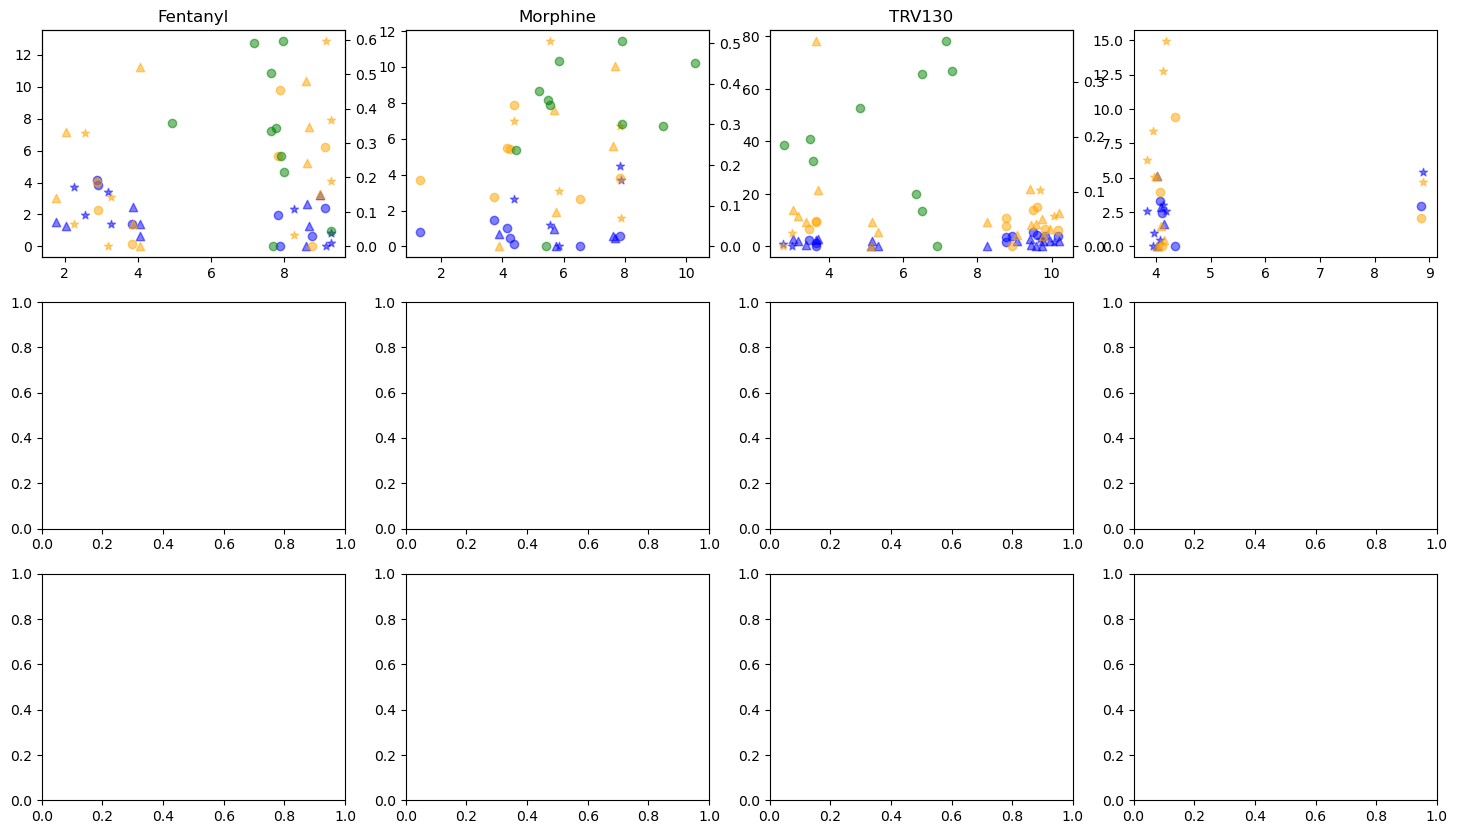

In [29]:
# Let's restart here and try again ok, you can do this lol

def delta_G_clusters(cluster_size_arr, rmsd_dict):
    no_clusters = rmsd_dict.size
    delta_G_arr = np.zeros(no_clusters)
    # print(no_clusters)
    for i in range(no_clusters):
        delta_G_arr[i] = -8.3145*300*np.log((cluster_size_arr[i])/(cluster_size_arr[0]))
    return delta_G_arr/1000

def delta_G_ie(ie_arr, rmsd_dict):
    no_clusters = rmsd_dict.size
    delta_G_arr = np.zeros(no_clusters)

    min_ie = 0
    for energy in ie_arr:
        if energy<min_ie:
            min_ie = energy
    # print(no_clusters)
    for i in range(no_clusters):
        delta_G_arr[i] = ie_arr[i] - min_ie

    return delta_G_arr

def delta_G_docking(docking_scores_arr):
    return np.array([docking_scores_arr.iloc[i]-docking_scores_arr.iloc[0] for i in range(10)])




fig, ax = plt.subplots(3,4, figsize=(18,10))

#fentanyl 
cluster_sizes_dict['fentanyl_1'] = [122, 94,69,56,46,26,23]
cluster_sizes_dict['fentanyl_2'] = [76,59,45,45,43,41,28,26,21]
cluster_sizes_dict['fentanyl_3'] = [101,93,72,57,46,39,26,23]

fentanyl_rel_BFEs_1 = delta_G_clusters(cluster_sizes_dict['fentanyl_1'], rmsd_dict['fentanyl_1'])
fentanyl_rel_BFEs_2 = delta_G_clusters(cluster_sizes_dict['fentanyl_2'], rmsd_dict['fentanyl_2'])
fentanyl_rel_BFEs_3 = delta_G_clusters(cluster_sizes_dict['fentanyl_3'], rmsd_dict['fentanyl_3'])

ie_dict['fentanyl_1'] = [-28.4047,	-38.1763,	-38.0106,	-32.5264,	-31.9785, -35.9047,	-34.1438]
ie_dict['fentanyl_2'] = [-28.8488,	-39.1871,	-31.7337,	-32.0285,	-27.9566,	-36.1826,	-37.7803,	-33.9359, -35.8988]
ie_dict['fentanyl_3'] = [-23.7357,	-32.5195,	-28.7056,	-33.5481,	-29.4949,	-35.9047,	-36.618, -35.1978]

fentanyl_ies_1 = delta_G_ie(ie_dict['fentanyl_1'], rmsd_dict['fentanyl_1'])
fentanyl_ies_2 = delta_G_ie(ie_dict['fentanyl_2'], rmsd_dict['fentanyl_2'])
fentanyl_ies_3 = delta_G_ie(ie_dict['fentanyl_3'], rmsd_dict['fentanyl_3'])

fentanyl_docking_scores = delta_G_docking(docking_score_dict['fentanyl'])
ax2 = ax[0,0].twinx()
ax[0,0].scatter(rmsd_dict['fentanyl_1'], fentanyl_rel_BFEs_1, label = 'binding free energy', alpha=0.5, color = 'blue', marker='o')
ax[0,0].scatter(rmsd_dict['fentanyl_2'], fentanyl_rel_BFEs_2, label = 'binding free energy', alpha=0.5, color = 'blue',marker='^')
ax[0,0].scatter(rmsd_dict['fentanyl_3'], fentanyl_rel_BFEs_3, label = 'binding free energy', alpha=0.5, color = 'blue',marker='*')

ax[0,0].scatter(rmsd_dict['fentanyl_1'], fentanyl_ies_1, label = 'mean interaction energy', alpha=0.5, color = 'orange',marker='o')
ax[0,0].scatter(rmsd_dict['fentanyl_2'], fentanyl_ies_2, label = 'mean interaction energy', alpha=0.5,color = 'orange', marker='^')
ax[0,0].scatter(rmsd_dict['fentanyl_3'], fentanyl_ies_3, label = 'mean interaction energy', alpha=0.5, color = 'orange',marker='*')

ax2.scatter(docking_rmsd_dict['fentanyl'][:10], fentanyl_docking_scores, label = 'docking', color = 'green', alpha=0.5)
ax[0,0].set_title('Fentanyl')

#morphine 
cluster_sizes_dict['morphine_1'] = [47,44,39,37,34,31,26]
cluster_sizes_dict['morphine_2'] = [50,41,40,38,34]
cluster_sizes_dict['morphine_3'] = [329,204,115,74,55]

morphine_rel_BFEs_1 = delta_G_clusters(cluster_sizes_dict['morphine_1'], rmsd_dict['morphine_1'])
morphine_rel_BFEs_2 = delta_G_clusters(cluster_sizes_dict['morphine_2'], rmsd_dict['morphine_2'])
morphine_rel_BFEs_3 = delta_G_clusters(cluster_sizes_dict['morphine_3'], rmsd_dict['morphine_3'])

ie_dict['morphine_1'] = [-27.1295,	-21.8979,	-24.3582,	-25.9804,	-26.0702,	-24.2907,	-26.9916,	-27.3846,	-20.3507,	-25.224,	-19.1511,	-24.218,	-29.77,	-23.9955,	-24.154,	-29.3869,	-26.1767]
ie_dict['morphine_2'] = [-29.0042,	-20.8865,	-25.3187,	-30.9159,	-23.326,	-19.7004,	-26.2928,	-24.8983,	-20.2665,	-25.4772,	-29.743,	-26.8536,	-28.4433,	-22.9494,	-25.6995]
ie_dict['morphine_3'] = [-25.7584,	-17.3609,	-21.8248,	-27.2397,	-22.1205,	-18.1299,	-23.3193,	-24.4057,	-20.863,	-21.1956,	-28.8286,	-22.6488,	-25.2669]

morphine_ies_1 = delta_G_ie(ie_dict['morphine_1'], rmsd_dict['morphine_1'])
morphine_ies_2 = delta_G_ie(ie_dict['morphine_2'], rmsd_dict['morphine_2'])
morphine_ies_3 = delta_G_ie(ie_dict['morphine_3'], rmsd_dict['morphine_3'])

morphine_docking_scores = delta_G_docking(docking_score_dict['morphine'])
ax2 = ax[0,1].twinx()
ax[0,1].scatter(rmsd_dict['morphine_1'], morphine_rel_BFEs_1, label = 'binding free energy', alpha=0.5, color = 'blue', marker='o')
ax[0,1].scatter(rmsd_dict['morphine_2'], morphine_rel_BFEs_2, label = 'binding free energy', alpha=0.5, color = 'blue',marker='^')
ax[0,1].scatter(rmsd_dict['morphine_3'], morphine_rel_BFEs_3, label = 'binding free energy', alpha=0.5, color = 'blue',marker='*')

ax[0,1].scatter(rmsd_dict['morphine_1'], morphine_ies_1, label = 'mean interaction energy', alpha=0.5, color = 'orange',marker='o')
ax[0,1].scatter(rmsd_dict['morphine_2'], morphine_ies_2, label = 'mean interaction energy', alpha=0.5,color = 'orange', marker='^')
ax[0,1].scatter(rmsd_dict['morphine_3'], morphine_ies_3, label = 'mean interaction energy', alpha=0.5, color = 'orange',marker='*')

ax2.scatter(docking_rmsd_dict['morphine'][:10], morphine_docking_scores, label = 'docking', color = 'green', alpha=0.5)
ax[0,1].set_title('Morphine')

#TRV130
cluster_sizes_dict['TRV130_1'] = [197,114,103,72,44,42,39,39,36,21]
cluster_sizes_dict['TRV130_2'] = [84,82,82,82,81,71,70,38,37,36,35,35,34,30,28,28,26,22]
cluster_sizes_dict['TRV130_3'] = [72,53,39,24]

morphine_rel_BFEs_1 = delta_G_clusters(cluster_sizes_dict['TRV130_1'], rmsd_dict['TRV130_1'])
morphine_rel_BFEs_2 = delta_G_clusters(cluster_sizes_dict['TRV130_2'], rmsd_dict['TRV130_2'])
morphine_rel_BFEs_3 = delta_G_clusters(cluster_sizes_dict['TRV130_3'], rmsd_dict['TRV130_3'])

ie_dict['TRV130_1'] = [-35.2216,	-35.4903,	-33.8076,-38.1215,	-36.9872,	-44.8081,	-38.0973, -38.41,-29.9,-31.1,-38.65,35.65]
ie_dict['TRV130_2'] = [-32.482, -42.7825,	-37.0922,	-34.2325,	-33.3222,	-34.6499,	-33.6466,-36,-33.541,-38.41,-29.9,-31.1,-38.65,35.65, 	-20.863,	-21.1956,	-28.8286,	-22.6488]
ie_dict['TRV130_3'] = [-38.571,-43.673,-32.093, -22.1205,	-18.1299,	-23.3193,	-24.4057,	-20.863,	-21.1956,	-28.8286,	-22.6488 ]

morphine_ies_1 = delta_G_ie(ie_dict['TRV130_1'], rmsd_dict['TRV130_1'])
morphine_ies_2 = delta_G_ie(ie_dict['TRV130_2'], rmsd_dict['TRV130_2'])
morphine_ies_3 = delta_G_ie(ie_dict['TRV130_3'], rmsd_dict['TRV130_3'])

morphine_docking_scores = delta_G_docking(docking_score_dict['TRV130'])
ax2 = ax[0,2].twinx()
ax[0,2].scatter(rmsd_dict['TRV130_1'], morphine_rel_BFEs_1, label = 'binding free energy', alpha=0.5, color = 'blue', marker='o')
ax[0,2].scatter(rmsd_dict['TRV130_2'], morphine_rel_BFEs_2, label = 'binding free energy', alpha=0.5, color = 'blue',marker='^')
ax[0,2].scatter(rmsd_dict['TRV130_3'], morphine_rel_BFEs_3, label = 'binding free energy', alpha=0.5, color = 'blue',marker='*')

ax[0,2].scatter(rmsd_dict['TRV130_1'], morphine_ies_1, label = 'mean interaction energy', alpha=0.5, color = 'orange',marker='o')
ax[0,2].scatter(rmsd_dict['TRV130_2'], morphine_ies_2, label = 'mean interaction energy', alpha=0.5,color = 'orange', marker='^')
ax[0,2].scatter(rmsd_dict['TRV130_3'], morphine_ies_3, label = 'mean interaction energy', alpha=0.5, color = 'orange',marker='*')

ax2.scatter(docking_rmsd_dict['TRV130'][:10], morphine_docking_scores, label = 'docking', color = 'green', alpha=0.5)
ax[0,2].set_title('TRV130')

#mitragynine pseudoindoxyl
cluster_sizes_dict['mp_1'] = [170,65,52,45]
cluster_sizes_dict['mp_2'] = [231,175,74]
cluster_sizes_dict['mp_3'] = [248,203,168,89,89,75,28]

morphine_rel_BFEs_1 = delta_G_clusters(cluster_sizes_dict['mp_1'], rmsd_dict['mp_1'])
morphine_rel_BFEs_2 = delta_G_clusters(cluster_sizes_dict['mp_2'], rmsd_dict['mp_2'])
morphine_rel_BFEs_3 = delta_G_clusters(cluster_sizes_dict['mp_3'], rmsd_dict['mp_3'])

ie_dict['mp_1'] = [-40.62686,	-50.069,	-48.0071,	-46.1298]
ie_dict['mp_2'] = [-37.203,	-41.8341,	-40.7977,	-42.3099]
ie_dict['mp_3'] = [-40.7566,	-49.1676,	-44.1277,	-42.8854,	-34.1946,	-36.40452,	-44.4639]

morphine_ies_1 = delta_G_ie(ie_dict['mp_1'], rmsd_dict['mp_1'])
morphine_ies_2 = delta_G_ie(ie_dict['mp_2'], rmsd_dict['mp_2'])
morphine_ies_3 = delta_G_ie(ie_dict['mp_3'], rmsd_dict['mp_3'])

morphine_docking_scores = delta_G_docking(docking_score_dict['mp'])
ax[0,3].scatter(rmsd_dict['mp_1'], morphine_rel_BFEs_1, label = 'binding free energy', alpha=0.5, color = 'blue', marker='o')
ax[0,3].scatter(rmsd_dict['mp_2'], morphine_rel_BFEs_2, label = 'binding free energy', alpha=0.5, color = 'blue',marker='^')
ax[0,3].scatter(rmsd_dict['mp_3'], morphine_rel_BFEs_3, label = 'binding free energy', alpha=0.5, color = 'blue',marker='*')

ax[0,3].scatter(rmsd_dict['mp_1'], morphine_ies_1, label = 'mean interaction energy', alpha=0.5, color = 'orange',marker='o')
ax[0,3].scatter(rmsd_dict['mp_2'], morphine_ies_2, label = 'mean interaction energy', alpha=0.5,color = 'orange', marker='^')
ax[0,3].scatter(rmsd_dict['mp_3'], morphine_ies_3, label = 'mean interaction energy', alpha=0.5, color = 'orange',marker='*')

ax[0,3].scatter(docking_rmsd_dict['mp'][:5], morphine_docking_scores, label = 'docking', color = 'green', alpha=0.5)
ax[0,3].set_title('mitragynine pseudoidoxyl')

#c5guano 
cluster_sizes_dict['c5guano_1'] = [25]
cluster_sizes_dict['c5guano_2'] = [95,67,63,56,49,43]
cluster_sizes_dict['c5guano_3'] = [126,115,100,34,32,32,26]

morphine_rel_BFEs_1 = delta_G_clusters(cluster_sizes_dict['c5guano_1'], rmsd_dict['c5guano_1'])
morphine_rel_BFEs_2 = delta_G_clusters(cluster_sizes_dict['c5guano_2'], rmsd_dict['c5guano_2'])
morphine_rel_BFEs_3 = delta_G_clusters(cluster_sizes_dict['c5guano_3'], rmsd_dict['c5guano_3'])

ie_dict['c5guano_1'] = [-35.839]
ie_dict['c5guano_2'] = [-32.4689,	-48.19,	-39.709,	-37.5134,	-52.1678,	-43.6807]
ie_dict['c5guano_3'] = [-34.455,	-52.4583,	-37.5087,	-33.5832,	-58.1269,	-27.841	,-31.9604]

morphine_ies_1 = delta_G_ie(ie_dict['c5guano_1'], rmsd_dict['c5guano_1'])
morphine_ies_2 = delta_G_ie(ie_dict['c5guano_2'], rmsd_dict['c5guano_2'])
morphine_ies_3 = delta_G_ie(ie_dict['c5guano_3'], rmsd_dict['c5guano_3'])

morphine_docking_scores = delta_G_docking(docking_score_dict['c5guano'])
ax[1,0].scatter(rmsd_dict['c5guano_1'], morphine_rel_BFEs_1, label = 'binding free energy', alpha=0.5, color = 'blue', marker='o')
ax[1,0].scatter(rmsd_dict['c5guano_2'], morphine_rel_BFEs_2, label = 'binding free energy', alpha=0.5, color = 'blue',marker='^')
ax[1,0].scatter(rmsd_dict['c5guano_3'], morphine_rel_BFEs_3, label = 'binding free energy', alpha=0.5, color = 'blue',marker='*')

ax[1,0].scatter(rmsd_dict['c5guano_1'], morphine_ies_1, label = 'mean interaction energy', alpha=0.5, color = 'orange',marker='o')
ax[1,0].scatter(rmsd_dict['c5guano_2'], morphine_ies_2, label = 'mean interaction energy', alpha=0.5,color = 'orange', marker='^')
ax[1,0].scatter(rmsd_dict['c5guano_3'], morphine_ies_3, label = 'mean interaction energy', alpha=0.5, color = 'orange',marker='*')

ax[1,0].scatter(docking_rmsd_dict['c5guano'][:5], morphine_docking_scores, label = 'docking', color = 'green', alpha=0.5)
ax[1,0].set_title('c5guano')

#c6guano 
cluster_sizes_dict['c6guano_1'] = [127,105,102,101,41,41,35,28]
cluster_sizes_dict['c6guano_2'] = [134,72,56,46,35,30,27,27,22,21]
cluster_sizes_dict['c6guano_3'] = [99,65,64,32,31,23]

morphine_rel_BFEs_1 = delta_G_clusters(cluster_sizes_dict['c6guano_1'], rmsd_dict['c6guano_1'])
morphine_rel_BFEs_2 = delta_G_clusters(cluster_sizes_dict['c6guano_2'], rmsd_dict['c6guano_2'])
morphine_rel_BFEs_3 = delta_G_clusters(cluster_sizes_dict['c6guano_3'], rmsd_dict['c6guano_3'])

ie_dict['c6guano_1'] = [-62.1559,	-43.0122,	-59.95,	-47.1	,-52.6878,	-41.3546,	-41.464, -48.169, -46.596, -42.509]
ie_dict['c6guano_2'] = [-51.5046,	-41.41,	-55.5967,	-44.3428,	-49.1191,	-40.4256,	-41.8072	-52.3088,	-45.375,	-41.7541, -51.754, -53.775, -56.843]
ie_dict['c6guano_3'] = [-57.8024,	-35.6718,	-56.2699,	-41.5641,	-51.1047,	-57.7257]


morphine_ies_1 = delta_G_ie(ie_dict['c6guano_1'], rmsd_dict['c6guano_1'])
morphine_ies_2 = delta_G_ie(ie_dict['c6guano_2'], rmsd_dict['c6guano_2'])
morphine_ies_3 = delta_G_ie(ie_dict['c6guano_3'], rmsd_dict['c6guano_3'])

morphine_docking_scores = delta_G_docking(docking_score_dict['c6guano'])
ax[1,1].scatter(rmsd_dict['c6guano_1'], morphine_rel_BFEs_1, label = 'binding free energy', alpha=0.5, color = 'blue', marker='o')
ax[1,1].scatter(rmsd_dict['c6guano_2'], morphine_rel_BFEs_2, label = 'binding free energy', alpha=0.5, color = 'blue',marker='^')
ax[1,1].scatter(rmsd_dict['c6guano_3'], morphine_rel_BFEs_3, label = 'binding free energy', alpha=0.5, color = 'blue',marker='*')

ax[1,1].scatter(rmsd_dict['c6guano_1'], morphine_ies_1, label = 'mean interaction energy', alpha=0.5, color = 'orange',marker='o')
ax[1,1].scatter(rmsd_dict['c6guano_2'], morphine_ies_2, label = 'mean interaction energy', alpha=0.5,color = 'orange', marker='^')
ax[1,1].scatter(rmsd_dict['c6guano_3'], morphine_ies_3, label = 'mean interaction energy', alpha=0.5, color = 'orange',marker='*')

ax[1,1].scatter(docking_rmsd_dict['c6guano'][:5], morphine_docking_scores, label = 'docking', color = 'green', alpha=0.5)
ax[1,1].set_title('c6guano')

#DAMGO
cluster_sizes_dict['DAMGO_1'] = [118,106,85,82,53,23]
cluster_sizes_dict['DAMGO_2'] = [42,41]
cluster_sizes_dict['DAMGO_3'] = [225,118,92,44]

morphine_rel_BFEs_1 = delta_G_clusters(cluster_sizes_dict['DAMGO_1'], rmsd_dict['DAMGO_1'])
morphine_rel_BFEs_2 = delta_G_clusters(cluster_sizes_dict['DAMGO_2'], rmsd_dict['DAMGO_2'])
morphine_rel_BFEs_3 = delta_G_clusters(cluster_sizes_dict['DAMGO_3'], rmsd_dict['DAMGO_3'])

ie_dict['DAMGO_1'] = [-53.1141,	-65.9767,	-72.9061,	-49.7656,	-57.4684, -66.5561]
ie_dict['DAMGO_2'] = [-57.2418,	-62.8215]
ie_dict['DAMGO_3'] = [-59.4009, -69.05,	-78.5641,	-52.5456]


morphine_ies_1 = delta_G_ie(ie_dict['DAMGO_1'], rmsd_dict['DAMGO_1'])
morphine_ies_2 = delta_G_ie(ie_dict['DAMGO_2'], rmsd_dict['DAMGO_2'])
morphine_ies_3 = delta_G_ie(ie_dict['DAMGO_3'], rmsd_dict['DAMGO_3'])

morphine_docking_scores = delta_G_docking(docking_score_dict['DAMGO'])
ax[1,2].scatter(rmsd_dict['DAMGO_1'], morphine_rel_BFEs_1, label = 'binding free energy', alpha=0.5, color = 'blue', marker='o')
ax[1,2].scatter(rmsd_dict['DAMGO_2'], morphine_rel_BFEs_2, label = 'binding free energy', alpha=0.5, color = 'blue',marker='^')
ax[1,2].scatter(rmsd_dict['DAMGO_3'], morphine_rel_BFEs_3, label = 'binding free energy', alpha=0.5, color = 'blue',marker='*')

ax[1,2].scatter(rmsd_dict['DAMGO_1'], morphine_ies_1, label = 'mean interaction energy', alpha=0.5, color = 'orange',marker='o')
ax[1,2].scatter(rmsd_dict['DAMGO_2'], morphine_ies_2, label = 'mean interaction energy', alpha=0.5,color = 'orange', marker='^')
ax[1,2].scatter(rmsd_dict['DAMGO_3'], morphine_ies_3, label = 'mean interaction energy', alpha=0.5, color = 'orange',marker='*')

ax[1,2].scatter(docking_rmsd_dict['DAMGO'][:5], morphine_docking_scores, label = 'docking', color = 'green', alpha=0.5)
ax[1,2].set_title('DAMGO')

#Lofentanil
cluster_sizes_dict['LFT_1'] = [216,157,116,87,42,41,28,20,20]
cluster_sizes_dict['LFT_2'] = [111,70,67,60,57,56,53,24]
cluster_sizes_dict['LFT_3'] = [95,79,46,44,43,40,27,25]

morphine_rel_BFEs_1 = delta_G_clusters(cluster_sizes_dict['LFT_1'], rmsd_dict['LFT_1'])
morphine_rel_BFEs_2 = delta_G_clusters(cluster_sizes_dict['LFT_2'], rmsd_dict['LFT_2'])
morphine_rel_BFEs_3 = delta_G_clusters(cluster_sizes_dict['LFT_3'], rmsd_dict['LFT_3'])

ie_dict['LFT_1'] = [-62.1559,	-43.0122,	-59.95,	-47.1	,-52.6878,	-41.3546,	-41.464, -48.169, -46.596, -42.509]
ie_dict['LFT_2'] = [-51.5046,	-41.41,	-55.5967,	-44.3428,	-49.1191,	-40.4256,	-41.8072	-52.3088,	-45.375,	-41.7541, -51.754, -53.775, -56.843]
ie_dict['LFT_3'] = [-57.8024,	-35.6718,	-56.2699,	-41.5641,	-51.1047,	-57.7257, -46.7456, -39.4102]


morphine_ies_1 = delta_G_ie(ie_dict['LFT_1'], rmsd_dict['LFT_1'])
morphine_ies_2 = delta_G_ie(ie_dict['LFT_2'], rmsd_dict['LFT_2'])
morphine_ies_3 = delta_G_ie(ie_dict['LFT_3'], rmsd_dict['LFT_3'])

morphine_docking_scores = delta_G_docking(docking_score_dict['LFT'])
ax[1,3].scatter(rmsd_dict['LFT_1'], morphine_rel_BFEs_1, label = 'binding free energy', alpha=0.5, color = 'blue', marker='o')
ax[1,3].scatter(rmsd_dict['LFT_2'], morphine_rel_BFEs_2, label = 'binding free energy', alpha=0.5, color = 'blue',marker='^')
ax[1,3].scatter(rmsd_dict['LFT_2'], morphine_rel_BFEs_3, label = 'binding free energy', alpha=0.5, color = 'blue',marker='*')

ax[1,3].scatter(rmsd_dict['LFT_1'], morphine_ies_1, label = 'mean interaction energy', alpha=0.5, color = 'orange',marker='o')
ax[1,3].scatter(rmsd_dict['LFT_2'], morphine_ies_2, label = 'mean interaction energy', alpha=0.5,color = 'orange', marker='^')
ax[1,3].scatter(rmsd_dict['LFT_3'], morphine_ies_3, label = 'mean interaction energy', alpha=0.5, color = 'orange',marker='*')

ax[1,3].scatter(docking_rmsd_dict['LFT'][:5], morphine_docking_scores, label = 'docking', color = 'green', alpha=0.5)
ax[1,3].set_title('Lofentanil')

#SR17018
cluster_sizes_dict['SR17018_1'] = [32,23]
cluster_sizes_dict['SR17018_2'] = [184,159,156,128,118,92,47]
cluster_sizes_dict['SR17018_3'] = [128,116,66,54,34]

morphine_rel_BFEs_1 = delta_G_clusters(cluster_sizes_dict['SR17018_1'], rmsd_dict['SR17018_1'])
morphine_rel_BFEs_2 = delta_G_clusters(cluster_sizes_dict['SR17018_2'], rmsd_dict['SR17018_2'])
morphine_rel_BFEs_3 = delta_G_clusters(cluster_sizes_dict['SR17018_3'], rmsd_dict['SR17018_3'])

ie_dict['SR17018_1'] = [-47.1,	-43.0122,	-59.95,	-47.1	,-52.6878,	-41.3546,	-41.464, -48.169, -46.596, -42.509]
ie_dict['SR17018_2'] = [-38.4071,	-42.2159,	-47.888,	-41.4279,	-44.0832,	-40.4256,	-41.8072	-52.3088,	-45.375,	-41.7541, -51.754, -53.775, -56.843]
ie_dict['SR17018_3'] = [-46.7456,	-35.6718,	-56.2699,	-41.5641,	-51.1047,	-57.7257, -46.7456, -39.4102]


morphine_ies_1 = delta_G_ie(ie_dict['SR17018_1'], rmsd_dict['SR17018_1'])
morphine_ies_2 = delta_G_ie(ie_dict['SR17018_2'], rmsd_dict['SR17018_2'])
morphine_ies_3 = delta_G_ie(ie_dict['SR17018_3'], rmsd_dict['SR17018_3'])

morphine_docking_scores = delta_G_docking(docking_score_dict['SR17018'])
ax[2,0].scatter(rmsd_dict['SR17018_1'], morphine_rel_BFEs_1, label = 'binding free energy', alpha=0.5, color = 'blue', marker='o')
ax[2,0].scatter(rmsd_dict['SR17018_2'], morphine_rel_BFEs_2, label = 'binding free energy', alpha=0.5, color = 'blue',marker='^')
ax[2,0].scatter(rmsd_dict['SR17018_3'], morphine_rel_BFEs_3, label = 'binding free energy', alpha=0.5, color = 'blue',marker='*')

ax[2,0].scatter(rmsd_dict['SR17018_1'], morphine_ies_1, label = 'mean interaction energy', alpha=0.5, color = 'orange',marker='o')
ax[2,0].scatter(rmsd_dict['SR17018_2'], morphine_ies_2, label = 'mean interaction energy', alpha=0.5,color = 'orange', marker='^')
ax[2,0].scatter(rmsd_dict['SR17018_3'], morphine_ies_3, label = 'mean interaction energy', alpha=0.5, color = 'orange',marker='*')

ax[2,0].scatter(docking_rmsd_dict['SR17018'][:5], morphine_docking_scores, label = 'docking', color = 'green', alpha=0.5)
ax[2,0].set_title('SR17018')

#PZM21
cluster_sizes_dict['PZM21_1'] = [338,122,107,54,51,22]
cluster_sizes_dict['PZM21_2'] = [215,204,149,144,142,107,61]
cluster_sizes_dict['PZM21_3'] = [99,95,94,45,31,27,27,24,21]

morphine_rel_BFEs_1 = delta_G_clusters(cluster_sizes_dict['PZM21_1'], rmsd_dict['PZM21_1'])
morphine_rel_BFEs_2 = delta_G_clusters(cluster_sizes_dict['PZM21_2'], rmsd_dict['PZM21_2'])
morphine_rel_BFEs_3 = delta_G_clusters(cluster_sizes_dict['PZM21_3'], rmsd_dict['PZM21_3'])

# ie_dict['PZM21_1'] = [-62.1559,	-43.0122,	-59.95,	-47.1	,-52.6878,	-41.3546,	-41.464, -48.169, -46.596, -42.509]
# ie_dict['PZM21_2'] = [-38.6619,	-35.4878,	-28.3308,	-49.5498,	-36.5349,	-46.4306,	-42.9266,	-46.0442,	-38.2831,	-31.843,	-38.4138]
# ie_dict['PZM21_3'] = [-57.8024,	-35.6718,	-56.2699,	-41.5641,	-51.1047,	-57.7257 -51.1047,	-57.7257, -46.7456, -39.4102]


# morphine_ies_1 = delta_G_ie(ie_dict['PZM21_1'], rmsd_dict['PZM21_1'])
# morphine_ies_2 = delta_G_ie(ie_dict['PZM21_2'], rmsd_dict['PZM21_2'])
# morphine_ies_3 = delta_G_ie(ie_dict['PZM21_3'], rmsd_dict['PZM21_3'])

morphine_docking_scores = delta_G_docking(docking_score_dict['PZM21'])
ax[2,1].scatter(rmsd_dict['PZM21_1'], morphine_rel_BFEs_1, label = 'binding free energy', alpha=0.5, color = 'blue', marker='o')
ax[2,1].scatter(rmsd_dict['PZM21_2'], morphine_rel_BFEs_2, label = 'binding free energy', alpha=0.5, color = 'blue',marker='^')
ax[2,1].scatter(rmsd_dict['PZM21_3'], morphine_rel_BFEs_3, label = 'binding free energy', alpha=0.5, color = 'blue',marker='*')

ax[2,1].scatter(rmsd_dict['PZM21_1'], morphine_ies_1, label = 'mean interaction energy', alpha=0.5, color = 'orange',marker='o')
ax[2,1].scatter(rmsd_dict['PZM21_2'], morphine_ies_2, label = 'mean interaction energy', alpha=0.5,color = 'orange', marker='^')
ax[2,1].scatter(rmsd_dict['PZM21_3'], morphine_ies_3, label = 'mean interaction energy', alpha=0.5, color = 'orange',marker='*')

ax[2,1].scatter(docking_rmsd_dict['PZM21'][:5], morphine_docking_scores, label = 'docking', color = 'green', alpha=0.5)
ax[2,1].set_title('PZM21')

#FH210
# cluster_sizes_dict['FH210_1'] = [338,122,107,54,51,22]
# cluster_sizes_dict['FH210_2'] = [215,204,149,144,142,107,61]
# cluster_sizes_dict['FH210_3'] = [99,95,94,45,31,27,27,24,21]

# morphine_rel_BFEs_1 = delta_G_clusters(cluster_sizes_dict['FH210_1'], rmsd_dict['FH210_1'])
# morphine_rel_BFEs_2 = delta_G_clusters(cluster_sizes_dict['FH210_2'], rmsd_dict['FH210_2'])
# morphine_rel_BFEs_3 = delta_G_clusters(cluster_sizes_dict['FH210_3'], rmsd_dict['FH210_3'])

# ie_dict['FH210_1'] = [-62.1559,	-43.0122,	-59.95,	-47.1	,-52.6878,	-41.3546,	-41.464, -48.169, -46.596, -42.509]
# ie_dict['FH210_2'] = [-38.6619,	-35.4878,	-28.3308,	-49.5498,	-36.5349,	-46.4306,	-42.9266,	-46.0442,	-38.2831,	-31.843,	-38.4138]
# ie_dict['FH210_3'] = [-57.8024,	-35.6718,	-56.2699,	-41.5641,	-51.1047,	-57.7257 -51.1047,	-57.7257, -46.7456, -39.4102]


# morphine_ies_1 = delta_G_ie(ie_dict['FH210_1'], rmsd_dict['FH210_1'])
# morphine_ies_2 = delta_G_ie(ie_dict['FH210_2'], rmsd_dict['FH210_2'])
# morphine_ies_3 = delta_G_ie(ie_dict['FH210_3'], rmsd_dict['FH210_3'])

# morphine_docking_scores = delta_G_docking(docking_score_dict['PZM21'])
# ax[2,1].scatter(rmsd_dict['FH210_1'], morphine_rel_BFEs_1, label = 'binding free energy', alpha=0.5, color = 'blue', marker='o')
# ax[2,1].scatter(rmsd_dict['FH210_2'], morphine_rel_BFEs_2, label = 'binding free energy', alpha=0.5, color = 'blue',marker='^')
# ax[2,1].scatter(rmsd_dict['FH210_3'], morphine_rel_BFEs_3, label = 'binding free energy', alpha=0.5, color = 'blue',marker='*')

# ax[2,1].scatter(rmsd_dict['FH210_1'], morphine_ies_1, label = 'mean interaction energy', alpha=0.5, color = 'orange',marker='o')
# ax[2,1].scatter(rmsd_dict['FH210_2'], morphine_ies_2, label = 'mean interaction energy', alpha=0.5,color = 'orange', marker='^')
# ax[2,1].scatter(rmsd_dict['FH210_3'], morphine_ies_3, label = 'mean interaction energy', alpha=0.5, color = 'orange',marker='*')

# ax[2,1].scatter(docking_rmsd_dict['FH210'][:5], morphine_docking_scores, label = 'docking', color = 'green', alpha=0.5)
# ax[2,1].set_title('FH210')

fig.tight_layout(pad=1.8)
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(.93,0.3))

ax[2,3].set_axis_off()
ax[2,2].set_axis_off()


for ax in ax.flat:
    ax.set_ylabel('\u0394BFE (kcal/mole)',labelpad=0)
    ax.set_xlabel('RMSD to CRYO pose ($\AA$)',labelpad=0)
    ax.set_ylim(-0.5,10)
    ax.set_xlim(1.5,10)
    ax.label_outer()


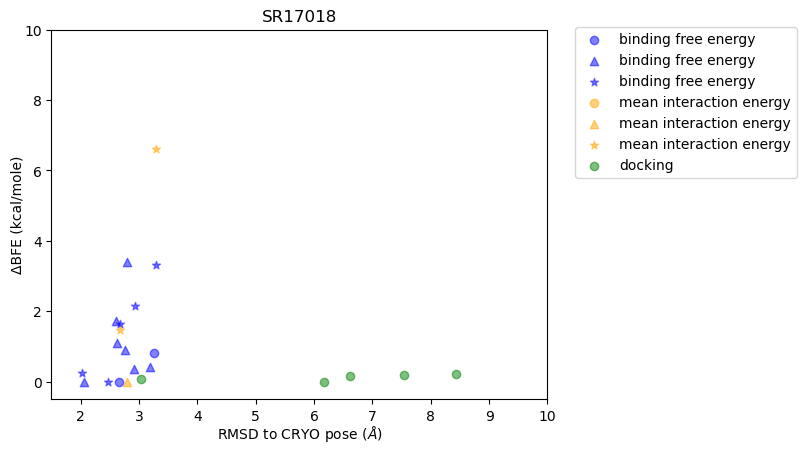

In [ ]:
fig, ax = plt.subplots()

cluster_sizes_dict['SR17018_1'] = [32,23]
cluster_sizes_dict['SR17018_2'] = [184,159,156,128,118,92,47]
cluster_sizes_dict['SR17018_3'] = [128,116,66,54,34]

morphine_rel_BFEs_1 = delta_G_clusters(cluster_sizes_dict['SR17018_1'], rmsd_dict['SR17018_1'])
morphine_rel_BFEs_2 = delta_G_clusters(cluster_sizes_dict['SR17018_2'], rmsd_dict['SR17018_2'])
morphine_rel_BFEs_3 = delta_G_clusters(cluster_sizes_dict['SR17018_3'], rmsd_dict['SR17018_3'])

ie_dict['SR17018_1'] = [-47.1,	-43.0122,	-59.95,	-47.1	,-52.6878,	-41.3546,	-41.464, -48.169, -46.596, -42.509]
ie_dict['SR17018_2'] = [-38.4071,	-42.2159,	-47.888,	-41.4279,	-44.0832,	-40.4256,	-41.8072	-52.3088,	-45.375,	-41.7541, -51.754, -53.775, -56.843]
ie_dict['SR17018_3'] = [-46.7456,	-35.6718,	-56.2699,	-41.5641,	-51.1047,	-57.7257, -46.7456, -39.4102]


morphine_ies_1 = delta_G_ie(ie_dict['SR17018_1'], rmsd_dict['SR17018_1'])
morphine_ies_2 = delta_G_ie(ie_dict['SR17018_2'], rmsd_dict['SR17018_2'])
morphine_ies_3 = delta_G_ie(ie_dict['SR17018_3'], rmsd_dict['SR17018_3'])

morphine_docking_scores = delta_G_docking(docking_score_dict['SR17018'])
ax.scatter(rmsd_dict['SR17018_1'], morphine_rel_BFEs_1, label = 'binding free energy', alpha=0.5, color = 'blue', marker='o')
ax.scatter(rmsd_dict['SR17018_2'], morphine_rel_BFEs_2, label = 'binding free energy', alpha=0.5, color = 'blue',marker='^')
ax.scatter(rmsd_dict['SR17018_3'], morphine_rel_BFEs_3, label = 'binding free energy', alpha=0.5, color = 'blue',marker='*')

ax.scatter(rmsd_dict['SR17018_1'], morphine_ies_1, label = 'mean interaction energy', alpha=0.5, color = 'orange',marker='o')
ax.scatter(rmsd_dict['SR17018_2'], morphine_ies_2, label = 'mean interaction energy', alpha=0.5,color = 'orange', marker='^')
ax.scatter(rmsd_dict['SR17018_3'], morphine_ies_3, label = 'mean interaction energy', alpha=0.5, color = 'orange',marker='*')

ax.scatter(docking_rmsd_dict['SR17018'][:5], morphine_docking_scores, label = 'docking', color = 'green', alpha=0.5)
ax.set_title('SR17018')


ax.set_ylabel('\u0394BFE (kcal/mole)',labelpad=0)
ax.set_xlabel('RMSD to CRYO pose ($\AA$)',labelpad=0)
ax.set_ylim(-0.5,10)
ax.set_xlim(1.5,10)
fig.legend(handles, labels, bbox_to_anchor=(1.3,.9))


In [ ]:
rmsd_dict['TRV130_1']

array([ 3.63202497,  3.65802404,  3.08805315,  8.72485184,  3.87877707,
        8.77740692, 10.17490225])